## La spiegazione di questo codice forse la metto forse no, sicuro fa riferimento a record_linkage

In [2]:
import recordlinkage
from recordlinkage import Compare
from recordlinkage.preprocessing import clean
import pandas as pd

companies_df = pd.read_csv('../aziende_normalizzate.csv')

C:\Users\matte\AppData\Local\Temp\ipykernel_7968\4040003662.py:6: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  companies_df = pd.read_csv('../aziende_normalizzate.csv')


### Stai attento peró che con l'approccio sotto riportato 2 righe matchano solo se entrambi i valori fanno match

In [ ]:
indexer = recordlinkage.Index()
indexer.block(left_on=['foundation_year', 'country'])  #proviamo solo su normalizzazione

candidate_pairs = indexer.index(companies_df)

print(f'Numero di coppie candidate: {len(candidate_pairs)}')

MemoryError: Unable to allocate 11.7 GiB for an array with shape (2, 783284344) and data type object

In [4]:
candidate_pairs_index = pd.MultiIndex.from_tuples(candidate_pairs, names=['left', 'right'])

companies_df = companies_df.reset_index(drop=True)

companies_df = companies_df.fillna("")

compare = Compare()
compare.string('city', 'city', method='jarowinkler', threshold=0.85, label='city')
compare.string('company_name', 'company_name', method='jarowinkler', threshold=0.85, label='company_name')

try:
    features = compare.compute(candidate_pairs_index, companies_df)
    display(features.head(10))
except Exception as e:
    print("Errore durante il calcolo delle feature sull'intero dataset:", e)

city  company_name
left right                    
7379 1015    0.0           0.0
7391 1015    0.0           0.0
     7379    0.0           0.0
7658 1015    0.0           0.0
     7379    0.0           0.0
     7391    0.0           0.0
7862 1015    0.0           0.0
     7379    0.0           0.0
     7391    0.0           0.0
     7658    0.0           0.0

In [6]:
matches = features[features.sum(axis=1) > 0.9]

print(f'Numero di corrispondenze trovate: {len(matches)}')

matches.head()

Numero di corrispondenze trovate: 3249


,,city,company_name
left,right,,
10936,10935,0.0,1.0
11489,11488,0.0,1.0
11572,11571,0.0,1.0
34307,34306,0.0,1.0
42325,42324,0.0,1.0


In [7]:
grouped_matches = matches.loc[matches.sum(axis=1).groupby(level=0).idxmax()]

grouped_matches.head(100)

,,city,company_name
left,right,,
1083,1082,0.0,1.0
1088,1087,0.0,1.0
1121,1120,0.0,1.0
1171,1170,0.0,1.0
1186,1185,0.0,1.0
...,...,...,...
7091,7090,0.0,1.0
7092,7090,0.0,1.0
7140,7139,0.0,1.0


In [9]:
import networkx as nx

def merge_values(series):
    unique_values = set(series.dropna())  # Rimuove i NaN e prende solo i valori unici
    return ' | '.join(map(str, unique_values)) if len(unique_values) > 0 else ''  # Concatena i valori

G = nx.Graph()
G.add_edges_from(grouped_matches.index.tolist())

connected_components = list(nx.connected_components(G))

duplicate_groups = {node: i for i, component in enumerate(connected_components) for node in component}

companies_df['group_id'] = companies_df.index.map(duplicate_groups)

def print_aggregated_rows(group_id, group_data):
    if len(group_data) >= 3:  
        print(f"\nAggregazione del gruppo {group_id} (con {len(group_data)} elementi):")
        group_data = group_data.reset_index()  
        print(group_data[['company_name', 'city', 'country', 'address']])  

final_df = companies_df.groupby('group_id').agg(merge_values).reset_index()

final_df = final_df.drop(columns=['group_id'])

for group_id, group_data in companies_df.groupby('group_id'):
    print_aggregated_rows(group_id, group_data)

final_df.to_csv("deduplicated_companies2.csv", index=False)

display(final_df.head())


Aggregazione del gruppo 6.0 (con 3 elementi):
  company_name city country address
0      7layers        italy        
1      7layers        italy        
2      7layers        italy        

Aggregazione del gruppo 7.0 (con 3 elementi):
  company_name city country address
0      84codes       sweden        
1      84codes       sweden        
2  84codes.com       sweden        

Aggregazione del gruppo 9.0 (con 3 elementi):
               company_name city  country address
0               a.u.e. genc       germany        
1               a.u.e. genc       germany        
2  a.u.e. genc warenhandels       germany        

Aggregazione del gruppo 14.0 (con 3 elementi):
  company_name city   country address
0      accedia       bulgaria        
1      accedia       bulgaria        
2  accedia jsc       bulgaria        

Aggregazione del gruppo 15.0 (con 3 elementi):
  company_name city  country address
0     accolade       czechia        
1     accolade       czechia        
2     accola

,company_id,company_name,trade_name,industry,sector,categories,company_status,company_type,headquarters,address,...,sic_code,emtak_code,nace_code,facebook,twitter,pinterest,instagram,investors,region,notes_or_description
0,,2c2p,,fintech,,,,,,,...,,,,,,,,,,
1,,2e vertriebs-gmbh | 2e vertriebs,,retail,,,,,,,...,,,,,,,,,,
2,,3c,,automobiles,,,,,,,...,,,,,,,,,,
3,,3zehn auto discount,,automobiles,,,,,,,...,,,,,,,,,,
4,,4most,,insurance,,,,,,,...,,,,,,,,,,


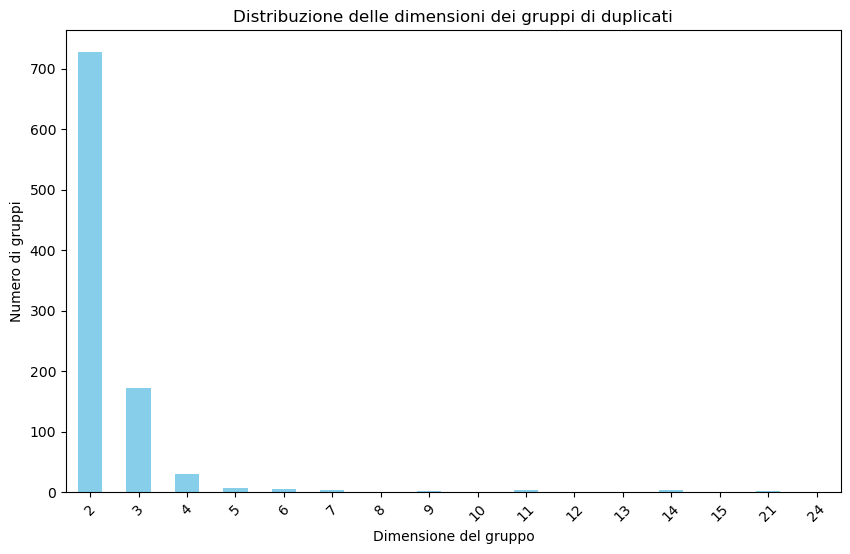

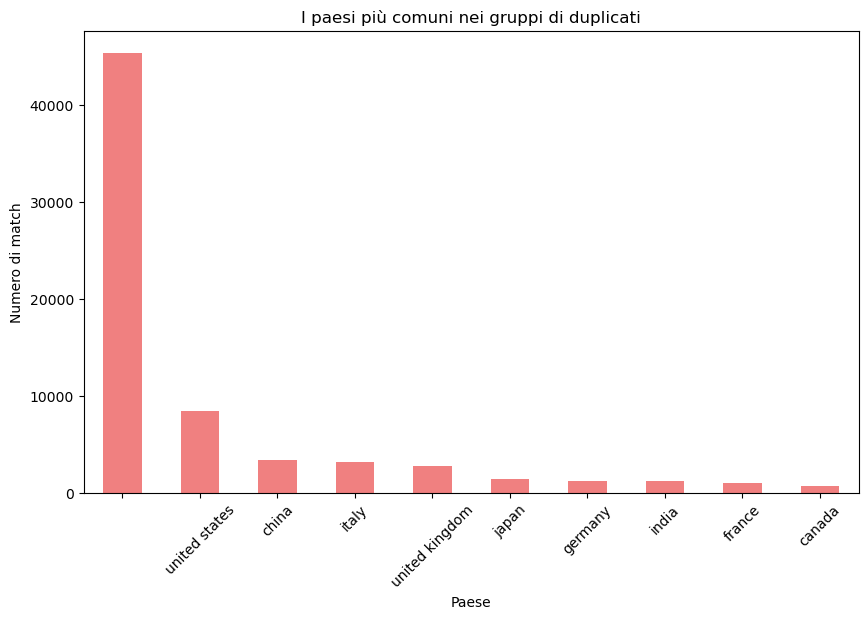

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


group_sizes = companies_df.groupby('group_id').size()

group_sizes_filtered = group_sizes[group_sizes > 1]

plt.figure(figsize=(10, 6))
group_sizes_filtered.value_counts().sort_index().plot(kind='bar', color='skyblue')

plt.title('Distribuzione delle dimensioni dei gruppi di duplicati')
plt.xlabel('Dimensione del gruppo')
plt.ylabel('Numero di gruppi')
plt.xticks(rotation=45)
plt.show()


country_counts = companies_df['country'].value_counts()
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar', color='lightcoral')
plt.title('I paesi più comuni nei gruppi di duplicati')
plt.xlabel('Paese')
plt.ylabel('Numero di match')
plt.xticks(rotation=45)
plt.show()